In [2]:
import tensorflow as tf
import numpy as np
from utils import *
from gtex_gan import *
import matplotlib
from collections import Counter
import itertools
from rnaseqdb import *
import pickle
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from sklearn.feature_selection import SelectKBest
from sklearn import tree
import fastcluster
from matplotlib.collections import EllipseCollection
from matplotlib.legend_handler import HandlerPatch

tfk = tf.keras
tfkl = tf.keras.layers

MODELS_DIR = 'checkpoints/models/'

In [3]:
def plot_distance_matrix(dist_m, v_min, v_max, symbols, title='Distance matrix'):
    ax = plt.gca()
    im = ax.imshow(dist_m, vmin=v_min, vmax=v_max)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(symbols)))
    ax.set_yticks(np.arange(len(symbols)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(symbols)
    ax.set_yticklabels(symbols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(symbols)):
        for j in range(len(symbols)):
            text = ax.text(j, i, '{:.2f}'.format(dist_m[i, j]),
                           ha="center", va="center", color="w")
    ax.set_title(title)


def plot_distance_matrices(x, y, symbols, corr_fn=pearson_correlation):
    """
    Plots distance matrices of both datasets x and y.
    :param x: matrix of gene expressions. Shape=(nb_samples_1, nb_genes)
    :param y: matrix of gene expressions. Shape=(nb_samples_2, nb_genes)
    :symbols: array of gene symbols. Shape=(nb_genes,)
    :param corr_fn: 2-d correlation function
    """

    dist_x = np.abs(1 - np.abs(corr_fn(x, x)))
    dist_y = np.abs(1 - np.abs(corr_fn(y, y)))
    v_min = min(np.min(dist_x), np.min(dist_y))
    v_max = min(np.max(dist_x), np.max(dist_y))

    # fig = plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plot_distance_matrix(dist_x, v_min, v_max, symbols, title='Distance matrix, real')
    plt.subplot(2, 1, 2)
    plot_distance_matrix(dist_y, v_min, v_max, symbols, title='Distance matrix, synthetic')
    # fig.tight_layout()
    return plt.gca()


def plot_corr_ellipses(data, ax=None, **kwargs):
    # https://stackoverflow.com/questions/34556180/how-can-i-plot-a-correlation-matrix-as-a-set-of-ellipses-similar-to-the-r-open
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


class Cluster:
    """
    Auxiliary class to store binary clusters
    """

    def __init__(self, c_left=None, c_right=None, index=None):
        assert (index is not None) ^ (c_left is not None and c_right is not None)
        self._c_left = c_left
        self._c_right = c_right
        if index is not None:
            self._indices = [index]
        else:
            self._indices = c_left.indices + c_right.indices

    @property
    def indices(self):
        return self._indices

    @property
    def c_left(self):
        return self._c_left

    @property
    def c_right(self):
        return self._c_right
    

def dendrogram_distance(l_matrix, condensed=True):
    """
    Computes the distances between each pair of genes according to the scipy linkage
    matrix.
    :param l_matrix: Scipy linkage matrix. Shape=(nb_genes-1, 4)
    :param condensed: whether to return the distances as a flat array containing the
           upper-triangular of the distance matrix
    :return: distances
    """
    nb_genes = l_matrix.shape[0] + 1

    # Fill distance matrix m
    clusters = {i: Cluster(index=i) for i in range(nb_genes)}
    m = np.zeros((nb_genes, nb_genes))
    for i, z in enumerate(l_matrix):
        c1, c2, dist, n_elems = z
        clusters[nb_genes + i] = Cluster(c_left=clusters[c1],
                                         c_right=clusters[c2])
        c1_indices = clusters[c1].indices
        c2_indices = clusters[c2].indices

        for c1_idx in c1_indices:
            for c2_idx in c2_indices:
                m[c1_idx, c2_idx] = dist
                m[c2_idx, c1_idx] = dist

    # Return flat array if condensed
    if condensed:
        return upper_diag_list(m)

    return m


def compare_cophenetic(l_matrix1, l_matrix2):
    """
    Computes the cophenic distance between two dendrograms given as scipy linkage matrices
    :param l_matrix1: Scipy linkage matrix. Shape=(nb_genes-1, 4)
    :param l_matrix2: Scipy linkage matrix. Shape=(nb_genes-1, 4)
    :return: cophenic distance between two dendrograms
    """
    dists1 = dendrogram_distance(l_matrix1, condensed=True)
    dists2 = dendrogram_distance(l_matrix2, condensed=True)

    return pearson_correlation(dists1, dists2)

def hierarchical_clustering(data, corr_fun=pearson_correlation):
    """
    Performs hierarchical clustering to cluster genes according to a gene similarity
    metric.
    Reference: Cluster analysis and display of genome-wide expression patterns
    :param data: numpy array. Shape=(nb_samples, nb_genes)
    :param corr_fun: function that computes the pairwise correlations between each pair
                     of genes in data
    :return scipy linkage matrix
    """
    # Perform hierarchical clustering
    y = 1 - correlations_list(data, data, corr_fun)
    # l_matrix = linkage(y, 'complete')  # 'correlation'
    l_matrix = fastcluster.linkage(y, method='complete')
    return l_matrix


def gamma_coefficients(expr_x, expr_z):
    """
    Compute gamma coefficients for two given expression matrices
    :param expr_x: matrix of gene expressions. Shape=(nb_samples_1, nb_genes)
    :param expr_z: matrix of gene expressions. Shape=(nb_samples_2, nb_genes)
    :return: Gamma(D^X, D^Z), Gamma(D^X, T^X), Gamma(D^Z, T^Z), Gamma(T^X, T^Z)
             where D^X and D^Z are the distance matrices of expr_x and expr_z (respectively),
             and T^X and T^Z are the dendrogrammatic distance matrices of expr_x and expr_z (respectively).
             Gamma(A, B) is a function that computes the correlation between the elements in the upper-diagonal
             of A and B.
    """
    # Compute Gamma(D^X, D^Z)
    dists_x = np.clip(1 - correlations_list(expr_x, expr_x), 0, 1)
    dists_z = np.clip(1 - correlations_list(expr_z, expr_z), 0, 1)
    gamma_dx_dz = pearson_correlation(dists_x, dists_z)

    # Compute Gamma(D^X, T^X)
    xl_matrix = hierarchical_clustering(expr_x)  # np.clip(, 0, 1)
    # sns.distplot(xl_matrix[:, 2].ravel())
    xl_matrix[:, 2] = np.clip(xl_matrix[:, 2], 0, a_max=None)
    
    gamma_dx_tx, _ = cophenet(xl_matrix, dists_x)

    # Compute Gamma(D^Z, T^Z)
    zl_matrix = hierarchical_clustering(expr_z)
    zl_matrix[:, 2] = np.clip(zl_matrix[:, 2], 0, a_max=None)
    gamma_dz_tz, _ = cophenet(zl_matrix, dists_z)

    # Compute Gamma(T^X, T^Z)
    gamma_tx_tz = compare_cophenetic(xl_matrix, zl_matrix)

    return gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz


def plot_dendr(x):
    Z = hierarchical_clustering(x)
    plt.figure(figsize=(8, 4))
    plt.title('Gen')
    with plt.rc_context({'lines.linewidth': 0.5}):
        dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000')
    ax = plt.gca()
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.savefig('figures/gen_dendr.pdf');
    # plt.axis('off')
    # plt.tight_layout()

In [4]:
# GPU limit
limit_gpu()

4 Physical GPUs, 1 Logical GPUs


In [5]:
gen = tfk.models.load_model(MODELS_DIR + 'gen_rnaseqdb.h5')

# Load dataset
expr_df, info_df = rnaseqdb_load()
x = expr_df.values.T
symbols = expr_df.index.levels[0].values
sampl_ids = expr_df.columns.values
tissues = info_df['TISSUE_GTEX'].values
datasets = info_df['DATASET'].values

x

... loading RNASeqDB dataset


array([[2.34570e+02, 1.23375e+03, 2.14700e+01, ..., 1.13800e+01,
        3.40200e+01, 1.11956e+03],
       [5.03950e+02, 3.28018e+03, 0.00000e+00, ..., 1.04000e+00,
        1.06630e+02, 1.12735e+03],
       [2.42880e+02, 7.88000e+00, 7.75000e+00, ..., 3.10000e+01,
        2.70500e+01, 2.13397e+03],
       ...,
       [1.73850e+02, 2.48000e+02, 1.85110e+02, ..., 5.54900e+01,
        6.33730e+02, 9.54430e+02],
       [5.36450e+02, 2.75280e+02, 1.47800e+01, ..., 8.90440e+02,
        2.38437e+03, 1.43715e+03],
       [9.81290e+02, 4.06671e+03, 3.09830e+02, ..., 1.39070e+02,
        2.55558e+03, 5.14560e+02]])

In [6]:
x_train, x_test = split_train_test(np.log(x + 1))


In [7]:
gen = tfk.models.load_model(MODELS_DIR + 'gen_rnaseqdb.h5')

# Load dataset
expr_df, info_df = rnaseqdb_load()
x = expr_df.values.T
symbols = expr_df.index.levels[0].values
sampl_ids = expr_df.columns.values
tissues = info_df['TISSUE_GTEX'].values
datasets = info_df['DATASET'].values

# TODO: REMOVE
# x, symbols, sampl_ids, tissues = load_gtex()
x = standardize(np.log(1 + x))
x = np.float32(x)

# Process categorical metadata
cat_dicts = []
tissues_dict_inv = np.array(list(sorted(set(tissues))))
tissues_dict = {t: i for i, t in enumerate(tissues_dict_inv)}
tissues = np.vectorize(lambda t: tissues_dict[t])(tissues)
cat_dicts.append(tissues_dict_inv)
dataset_dict_inv = np.array(list(sorted(set(datasets))))
dataset_dict = {d: i for i, d in enumerate(dataset_dict_inv)}
datasets = np.vectorize(lambda t: dataset_dict[t])(datasets)
cat_dicts.append(dataset_dict_inv)
cat_covs = np.concatenate((tissues[:, None], datasets[:, None]), axis=-1)

"""
# ----
tissues_dict_inv = np.array(list(sorted(set(tissues))))
tissues_dict = {t: i for i, t in enumerate(tissues_dict_inv)}
tissues = np.vectorize(lambda t: tissues_dict[t])(tissues)
cat_covs = tissues[:, None]
cat_dicts = [tissues_dict_inv]
# ----
"""

cat_covs = np.int32(cat_covs)
print('Cat covs: ', cat_covs.shape)

# Process numerical metadata
# num_cols = ['AGE']  # 'AGE'
# num_covs = df_metadata.loc[sampl_ids, num_cols].values
# num_covs = standardize(num_covs)
# num_covs = np.float32(num_covs)
num_covs = np.zeros((x.shape[0], 1), dtype=np.float32)
# num_covs = np.zeros_like(cat_covs).astype(np.float32)
print(num_covs.shape)
print('X shape: ', x.shape)

"""
TODO:
# Log-transform data
x = np.log(1 + x)
x = np.float32(x)

# Train/test split
np.random.seed(0)
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx, :]
num_covs = num_covs[idx, :]
cat_covs = cat_covs[idx, :]

x_train, x_test = split_train_test(x)
num_covs_train, num_covs_test = split_train_test(num_covs)
cat_covs_train, cat_covs_test = split_train_test(cat_covs)

# Normalise data
x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
x_train = standardize(x_train, mean=x_mean, std=x_std)
x_test = standardize(x_test, mean=x_mean, std=x_std)
"""


# Train/test split
np.random.seed(0)
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
print(idx)
x = x[idx, :]
num_covs = num_covs[idx, :]
cat_covs = cat_covs[idx, :]

x_train, x_test = split_train_test(x)
num_covs_train, num_covs_test = split_train_test(num_covs)
cat_covs_train, cat_covs_test = split_train_test(cat_covs)

# Evaluate data
print('Generating synthetic data...')
nb_samples=x_test.shape[0]
x_gen = predict(cc=cat_covs_test,
                nc=num_covs_test,
                gen=gen)

... loading RNASeqDB dataset
Cat covs:  (9147, 2)
(9147, 1)
X shape:  (9147, 18154)
[5454 7688 2860 ... 4859 3264 2732]
Generating synthetic data...


In [8]:
gene_list = ['TP53', 'TNF', 'VEGFA', 'APOE', 'IL6', 'TGFB1', 'MTHFR', 'ESR1', 'AKT1', 'HBB', 'CD4', 'GRB2']
gene_idxs = [np.argwhere(g.upper() == symbols).ravel()[0] for g in gene_list]
x_gen_s = x_gen[:, gene_idxs]
x_test_s = x_test[:, gene_idxs]
x_train_s = x_train[:, gene_idxs]

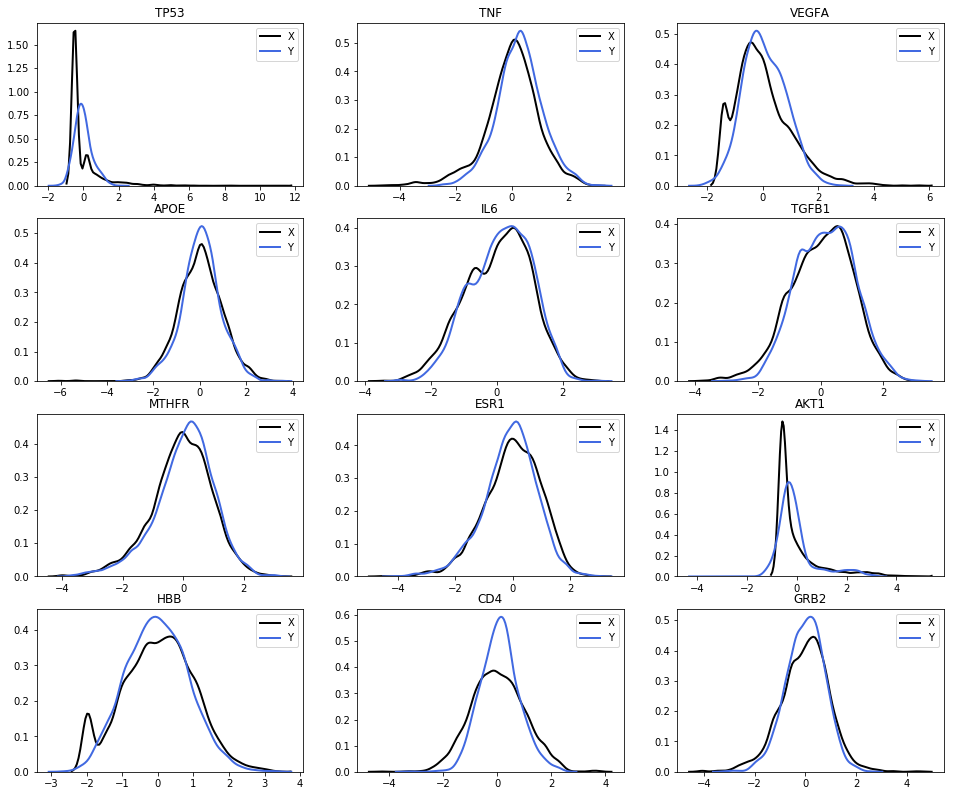

In [32]:
plt.figure(figsize=(14, 8))
plot_individual_distrs(x_test_s, x_gen_s, gene_list)

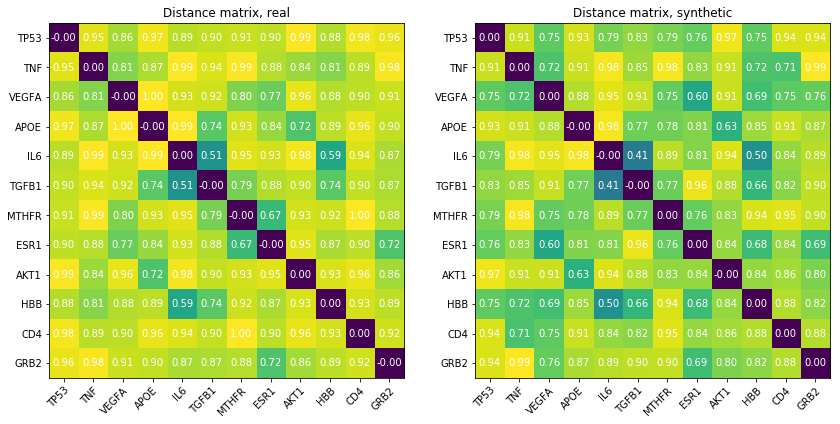

In [152]:
plt.figure(figsize=(14, 8))
plot_distance_matrices(x_test_s, x_gen_s, gene_list)
plt.savefig('figures/dist-matrix-global.pdf');

In [32]:
ec = EllipseCollection(widths=[1, 2], heights=[2, 1], angles=[30, 60], units='x')

In [36]:
{mpatches.Circle:HandlerPatch(patch_func=make_legend_ellipse)}

{matplotlib.patches.Circle: <matplotlib.legend_handler.HandlerPatch at 0x7f7b885a5fd0>}

1.000001
1.0000021
1.0000004


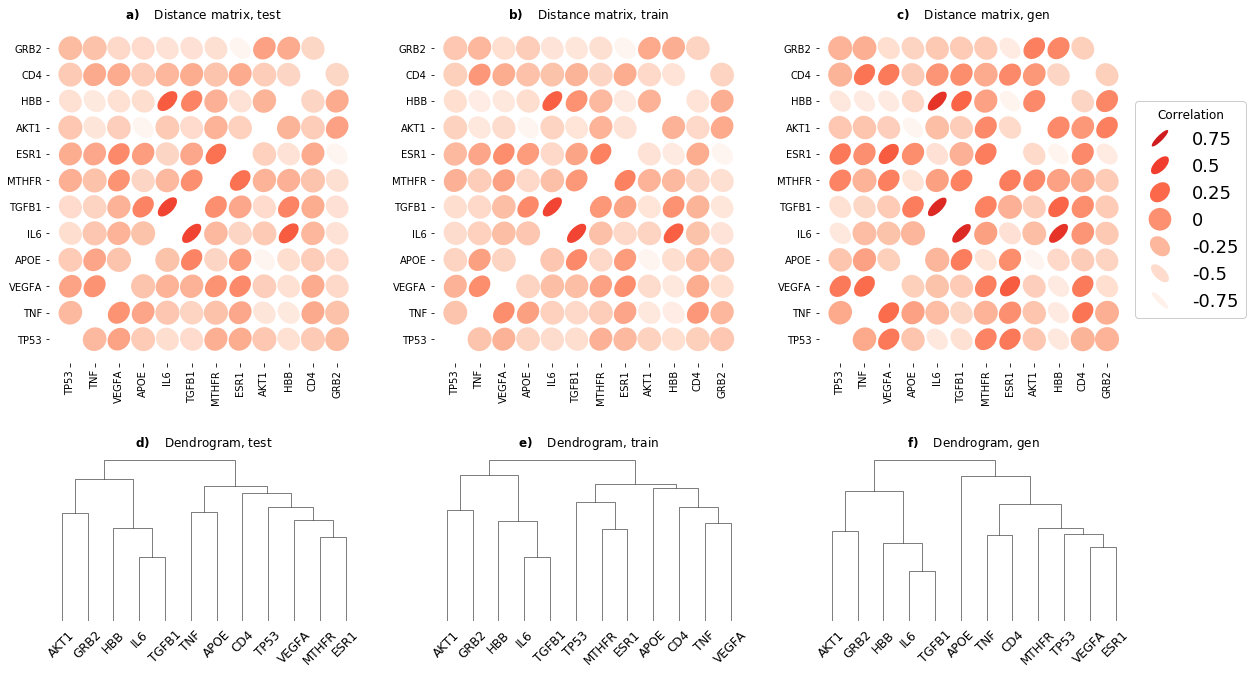

In [106]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import matplotlib as mpl

# plt.figure(figsize=(16, 14))
f, axes = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})
a0 = axes[0, 0]
a1 = axes[0, 1]
a2 = axes[0, 2]
a3 = axes[1, 0]
a4 = axes[1, 1]
a5 = axes[1, 2]

cmap = plt.cm.Reds  # or plt.cm.PiYG

# plt.subplot(2, 2, 1)
df = pd.DataFrame(pearson_correlation(x_test_s, x_test_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
# ax=sns.heatmap(df, annot=True, fmt=".2f", ax=a0, cbar=False, vmin=0, vmax=1.4)
ec = plot_corr_ellipses(df, ax=a0, cmap=cmap)
# plt.box(on=None)
a0.set_title('$\\bf{a)}$    Distance matrix, test')
a0.margins(0.08)
a0.spines["top"].set_visible(False)
a0.spines["right"].set_visible(False)
a0.spines["left"].set_visible(False)
a0.spines["bottom"].set_visible(False)

df = pd.DataFrame(pearson_correlation(x_train_s, x_train_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
ec = plot_corr_ellipses(df, ax=a1, cmap=cmap)
a1.set_title('$\\bf{b)}$    Distance matrix, train')
a1.margins(0.08)
a1.spines["top"].set_visible(False)
a1.spines["right"].set_visible(False)
a1.spines["left"].set_visible(False)
a1.spines["bottom"].set_visible(False)

# plt.subplot(2, 2, 2)
df = pd.DataFrame(pearson_correlation(x_gen_s, x_gen_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
ec = plot_corr_ellipses(df, ax=a2, cmap=cmap)
a2.set_title('$\\bf{c)}$    Distance matrix, gen')
a2.margins(0.08)
a2.spines["top"].set_visible(False)
a2.spines["right"].set_visible(False)
a2.spines["left"].set_visible(False)
a2.spines["bottom"].set_visible(False)

class HandlerEllipse(mpl.legend_handler.HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        d = float(orig_handle.get_label())
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        radius = (height + ydescent) * 1.8
        p = Ellipse(xy=center, width=radius, height=radius * (1 - abs(d)), angle=45 if d > 0 else -45)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

norm = mpl.colors.Normalize(vmin=-0.8, vmax=1.3)
values = [0.75, 0.5, 0.25, 0, -0.25, -0.5, -0.75]

shapes = [Circle((0.5, 0.5), 1, facecolor=cmap(norm(d)), alpha=1, zorder=2, linewidth=0, label=d)
          for d in values]
legend = a2.legend(handles=shapes, labels=values, title='Correlation', framealpha=1,
          prop={'size': 18},
           loc='upper center', bbox_to_anchor=(1.2, 0.8),
           handler_map={Circle: HandlerEllipse()})

plt.setp(legend.get_title(),fontsize='12')

# plt.subplot(2, 2, 3)
Z = hierarchical_clustering(x_test_s)
plt.title('Real')
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a3)
a3.get_yaxis().set_visible(False)
a3.set_title('$\\bf{d)}$    Dendrogram, test')
a3.spines["top"].set_visible(False)
a3.spines["right"].set_visible(False)
a3.spines["left"].set_visible(False)
a3.spines["bottom"].set_visible(False)

# plt.subplot(2, 2, 3)
Z = hierarchical_clustering(x_train_s)
plt.title('Real')
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a4)
a4.get_yaxis().set_visible(False)
a4.set_title('$\\bf{e)}$    Dendrogram, train')
a4.spines["top"].set_visible(False)
a4.spines["right"].set_visible(False)
a4.spines["left"].set_visible(False)
a4.spines["bottom"].set_visible(False)


# plt.subplot(2, 2, 4)
Z = hierarchical_clustering(x_gen_s)
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a5)
a5.get_yaxis().set_visible(False)
a5.set_title('$\\bf{f)}$    Dendrogram, gen')
a5.spines["top"].set_visible(False)
a5.spines["right"].set_visible(False)
a5.spines["left"].set_visible(False)
a5.spines["bottom"].set_visible(False)

f.tight_layout(pad=3.0)
plt.savefig('figures/dist_dendr_combined_ellipses.pdf');


In [83]:
norm(0.8)

0.9

In [42]:
x_train_s

array([[-0.4967511 ,  0.7041238 , -1.415466  , ...,  1.5662069 ,
         0.6566323 , -1.7483171 ],
       [ 1.2153404 , -0.886537  ,  4.38528   , ..., -0.5821115 ,
         0.956081  ,  1.2450997 ],
       [-0.4967511 ,  1.5662392 ,  2.4242918 , ..., -1.9761834 ,
         0.30054754, -1.1610384 ],
       ...,
       [-0.4967511 ,  1.3719617 ,  0.28269807, ..., -1.0120945 ,
        -0.29831392,  0.6009294 ],
       [-0.4967511 ,  0.9955441 ,  0.47124943, ..., -0.5553829 ,
         0.37339216,  1.2072002 ],
       [-0.4967511 ,  0.36413765, -0.52680105, ...,  0.31681666,
        -1.8036107 ,  0.10833193]], dtype=float32)

-7.34465e-07
-1.9265578e-06
-1.3841859e-07


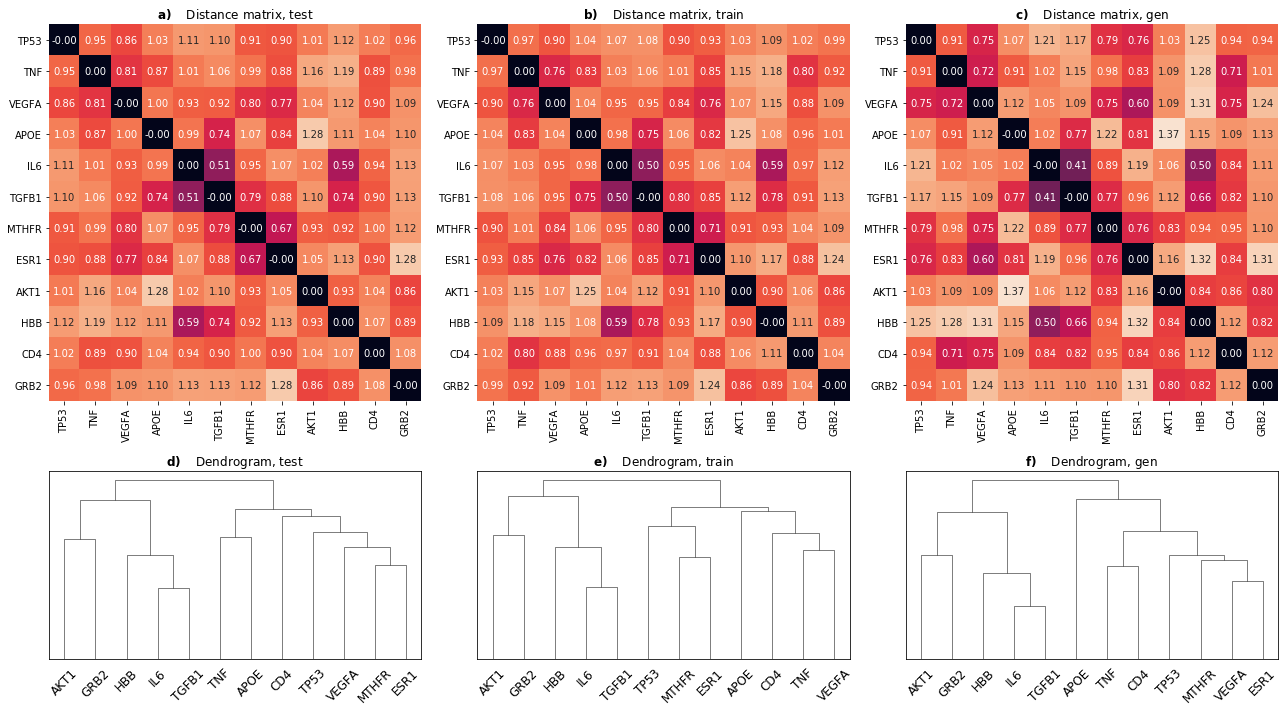

In [957]:
# plt.figure(figsize=(16, 14))
f, axes = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})
a0 = axes[0, 0]
a1 = axes[0, 1]
a2 = axes[0, 2]
a3 = axes[1, 0]
a4 = axes[1, 1]
a5 = axes[1, 2]

# plt.subplot(2, 2, 1)
df = pd.DataFrame(1 - pearson_correlation(x_test_s, x_test_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
ax=sns.heatmap(df, annot=True, fmt=".2f", ax=a0, cbar=False, vmin=0, vmax=1.4)
a0.set_title('$\\bf{a)}$    Distance matrix, test')

df = pd.DataFrame(1 - pearson_correlation(x_train_s, x_train_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
ax=sns.heatmap(df, annot=True, fmt=".2f", ax=a1, cbar=False, vmin=0, vmax=1.4)
a1.set_title('$\\bf{b)}$    Distance matrix, train')

# plt.subplot(2, 2, 2)
df = pd.DataFrame(1 - pearson_correlation(x_gen_s, x_gen_s)+1e-7, index=gene_list, columns=gene_list)
print(df.values.max())
sns.heatmap(df, annot=True, fmt=".2f", ax=a2, cbar=False, vmin=0, vmax=1.4)
a2.set_title('$\\bf{c)}$    Distance matrix, gen')

# plt.subplot(2, 2, 3)
Z = hierarchical_clustering(x_test_s)
plt.title('Real')
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a3)
a3.get_yaxis().set_visible(False)
a3.set_title('$\\bf{d)}$    Dendrogram, test')

# plt.subplot(2, 2, 3)
Z = hierarchical_clustering(x_train_s)
plt.title('Real')
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a4)
a4.get_yaxis().set_visible(False)
a4.set_title('$\\bf{e)}$    Dendrogram, train')


# plt.subplot(2, 2, 4)
Z = hierarchical_clustering(x_gen_s)
with plt.rc_context({'lines.linewidth': 0.5}):
    dn = dendrogram(Z, count_sort='ascending', labels=gene_list, leaf_rotation=45, link_color_func=lambda _: '#000000', ax=a5)
a5.get_yaxis().set_visible(False)
a5.set_title('$\\bf{f)}$    Dendrogram, gen')
f.tight_layout()
plt.savefig('figures/dist_dendr_combined.pdf');


In [68]:
gamma_coefficients(x_test_s, x_gen_s)

(11, 4)


(0.9084418325713186, 0.7332035573076, 0.7847996259234877, 0.9342669806987569)

In [83]:
gamma_coefficients(x_test_s, x_gen_s)

(0.9084418325713186, 0.7332035573076, 0.7847996259234877, 0.9342669806987569)

In [170]:
coefs = []
for _ in range(5):
    x_gen_ = predict(cc=cat_covs_test,
                nc=num_covs_test,
                gen=gen)
    c = gamma_coefficients(x_test, x_gen_)
    coefs.append(c)

In [176]:
coefs=np.array(coefs)  #  gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz
mse = (coefs[:, 1] - coefs[:, 2])**2

In [173]:
np.mean(coefs, axis=0)

array([0.92022049, 0.32585397, 0.39833854, 0.21514215])

In [174]:
np.std(coefs, axis=0)

array([0.00138156, 0.        , 0.00818524, 0.00534073])

In [179]:
np.mean(mse)

0.005321011387909697

In [180]:
np.std(mse)

0.001214085910090108

In [84]:
gamma_coefficients(x_test, x_gen)

(0.9189230480603704,
 0.3258539679173834,
 0.4137088069378161,
 0.21285593445811676)

In [88]:
idxs = np.random.choice(np.arange(x_train.shape[0], dtype=np.int), size=x_test.shape[0], replace=False)  # randint(cc.shape[0], size=bs)
gamma_coefficients(x_test, x_train[idxs, :])

(0.9485208783254278,
 0.3258539679173834,
 0.3712908451406233,
 0.22549441070361306)

In [181]:
coefs = []
for _ in range(5):
    idxs = np.random.choice(np.arange(x_train.shape[0], dtype=np.int), size=x_test.shape[0], replace=False)  # randint(cc.shape[0], size=bs)
    c = gamma_coefficients(x_test, x_train[idxs, :])
    coefs.append(c)

In [182]:
coefs=np.array(coefs)  #  gamma_dx_dz, gamma_dx_tx, gamma_dz_tz, gamma_tx_tz
mse = (coefs[:, 1] - coefs[:, 2])**2

In [183]:
np.mean(coefs, axis=0)

array([0.94753007, 0.32585397, 0.34383785, 0.22257986])

In [184]:
np.std(coefs, axis=0)

array([0.01657463, 0.        , 0.03040426, 0.01097903])

In [185]:
np.mean(mse)

0.0012478391882957854

In [186]:
np.std(mse)

0.0013650037262232788

# Save data

In [47]:
# Save data
data = {'x_gen': x_gen,
        'x_test': x_test,
        'cat_covs_test': cat_covs_test,
        'num_cov_test': num_covs_test,
        'tissues_dict_inv': tissues_dict_inv,
        'dataset_dict_inv': dataset_dict_inv,
        'idx_test': idx}
with open('data/rnaseqdb_gen.pkl', 'wb') as handle:
    pickle.dump(data, handle)

In [13]:
# Save generated data
bs = 64
n_gtex = 4*bs
n_tcga = 4*bs
n_tcga_t = 8*bs
n = n_gtex + n_tcga + n_tcga_t
selected_tissues = tissues_dict_inv # ['lung', 'thyroid', 'breast', 'colon', 'liver']
x_gen_ = np.zeros(((n_gtex+n_tcga+n_tcga_t)*len(selected_tissues), x_test.shape[-1]))
cat_covs_test_ = []
for i, t in enumerate(selected_tissues):
    cc_test = [[tissues_dict[t], 0]] * n_gtex + [[tissues_dict[t], 1]] * n_tcga + [[tissues_dict[t], 2]] * n_tcga_t
    nc_test = np.zeros(n)[:, None]
    cat_covs_test_ += cc_test

    for b in range(0, n, bs):
        print(b)
        xx = predict(cc=np.array(cc_test)[b:b+bs],
                     nc=np.array(nc_test)[b:b+bs],
                     gen=gen)
        x_gen_[i*n + b: i*n + b+bs] = xx
    
cat_covs_test_ = np.array(cat_covs_test_)
num_covs_test_ = np.zeros(cat_covs_test_.shape[0])[:, None]

cat_cov_test_.shape

0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960


ResourceExhaustedError: OOM when allocating tensor with shape[15360,18154] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

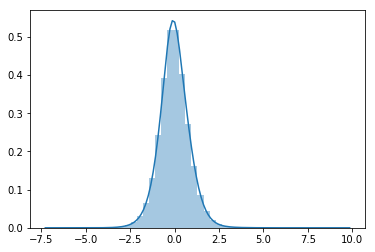

In [17]:
sns.distplot(x_gen_.ravel())

In [16]:
data = {'x_gen': x_gen_,
        'x_test': x_test,
        'cat_covs_test': cat_covs_test,
        'num_covs_test': num_covs_test,
        'cat_covs_test_gen': cat_covs_test_,
        'num_covs_test_gen': num_covs_test_,
        'tissues_dict_inv': tissues_dict_inv,
        'dataset_dict_inv': dataset_dict_inv,
        'selected_tissues': selected_tissues,
        'idx_test': idx}
filename = 'data/rnaseqdb_gen_balanced.pkl'
print('Saving data to {}'.format(filename))
with open(filename, 'wb') as handle:
    pickle.dump(data, handle)

Saving data to data/rnaseqdb_gen_balanced.pkl


# Cancer differential expression

In [5]:
cat_covs

array([[ 9,  2],
       [12,  2],
       [ 4,  0],
       ...,
       [ 8,  2],
       [ 6,  0],
       [ 4,  0]], dtype=int32)

In [6]:
tissues_dict

{'bladder': 0,
 'breast': 1,
 'cervix': 2,
 'colon': 3,
 'esophagus_gas': 4,
 'esophagus_muc': 5,
 'esophagus_mus': 6,
 'kidney': 7,
 'liver': 8,
 'lung': 9,
 'prostate': 10,
 'salivary': 11,
 'stomach': 12,
 'thyroid': 13,
 'uterus': 14}

In [7]:
Counter(cat_covs[:, 1])

Counter({0: 2322, 1: 683, 2: 6142})

In [41]:
t = 'prostate'
tissue = tissues_dict[t]
cc_ = np.zeros((2, cat_covs.shape[-1]))
cc_[:, 0] = tissue
cc_[0, 1] = 0
cc_[1, 1] = 2
nc_ = np.zeros((2, 1))

In [42]:
n = 1000
stds = []
z_dim = gen.input[0].shape[-1]

for i in range(n):
    # print(i)
    z = np.random.normal(0, 1, size=(1, z_dim))
    z = np.repeat(z, 2, axis=0)
    x_gen_c = predict(cc=cc_,
                         nc=nc_,
                         z=z,
                         gen=gen)
    diff = x_gen_c[0] - x_gen_c[1]
    stds.append(diff)
diffs = np.array(stds)

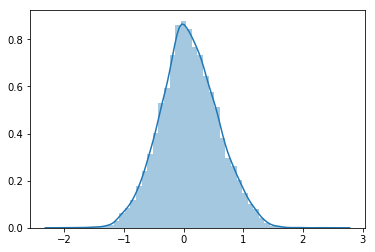

In [43]:
diff = np.mean(diffs, axis=0)
sns.distplot(diff);

In [44]:
diff.shape

(18154,)

In [51]:
idxs = np.argwhere(np.abs(diff) > 1.9)
symbols[idxs.ravel()]

array(['CASP3', 'FAM204A', 'GAGE1', 'HABP2', 'MTRNR2L8', 'PIF1', 'SSU72'],
      dtype=object)

In [52]:
for i, s in enumerate(symbols[idxs.ravel()]):
    sign = '+'
    if diff[idxs[i].ravel()].ravel() < 0:
        sign = '-'
    print(sign, ' ', s)

+   CASP3
+   FAM204A
+   GAGE1
-   HABP2
+   MTRNR2L8
+   PIF1
-   SSU72


In [20]:
idxs[0]

array([576])

In [13]:
idxs

array([[  576],
       [10634],
       [16042],
       [16230],
       [17258]])

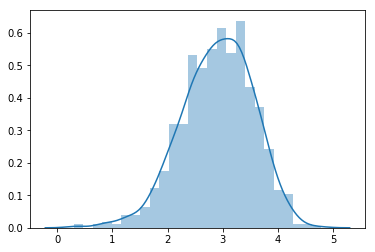

In [14]:
sns.distplot(diffs[:, 17258])

In [15]:
diffs.shape

(1000, 18154)

In [400]:
diffs_2d = tsne_2d(diffs)
diffs_2d

... performing tSNE


array([[-14.496998 ,  -2.9840662],
       [ 12.820663 , -21.125578 ],
       [-23.890505 ,  30.01964  ],
       ...,
       [-19.348122 ,  26.2702   ],
       [  4.595124 , -13.090352 ],
       [ 12.234878 ,  -4.208565 ]], dtype=float32)

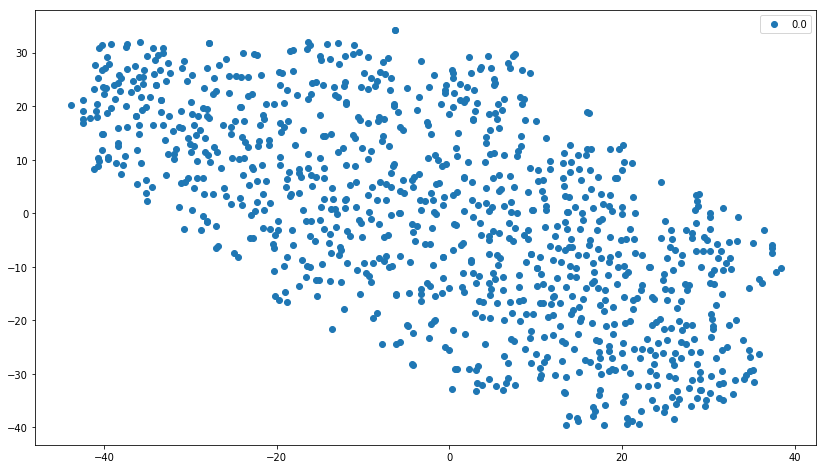

In [401]:
plt.figure(figsize=(14, 8))
plot_tsne_2d(diffs_2d, np.zeros(diffs_2d.shape[0]));

In [109]:
spectral = cluster.SpectralClustering(n_clusters=5, affinity="nearest_neighbors")
c = spectral.fit_predict(diffs_2d)
Counter(c)

Counter({0: 611, 1: 87, 2: 3, 3: 288, 4: 11})

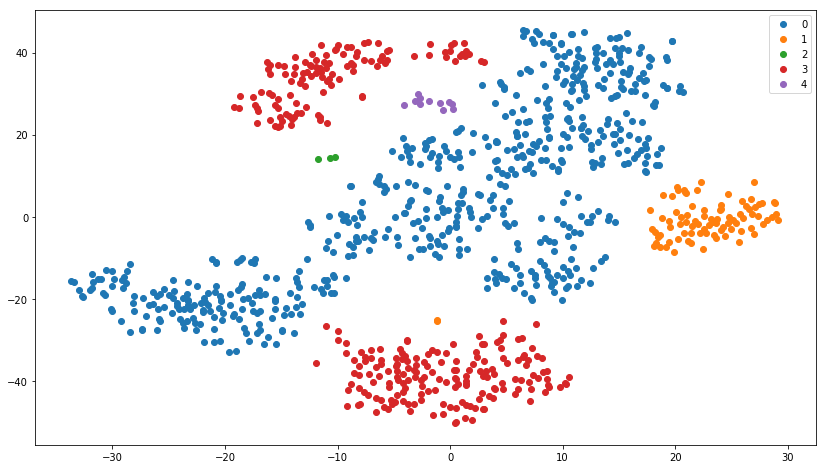

In [111]:
plt.figure(figsize=(14, 8))
plot_tsne_2d(diffs_2d, c);

In [19]:
clust = cluster.KMeans(n_clusters=7)
c = clust.fit_predict(diffs)
Counter(c)

Counter({0: 163, 1: 178, 2: 132, 3: 82, 4: 130, 5: 182, 6: 133})

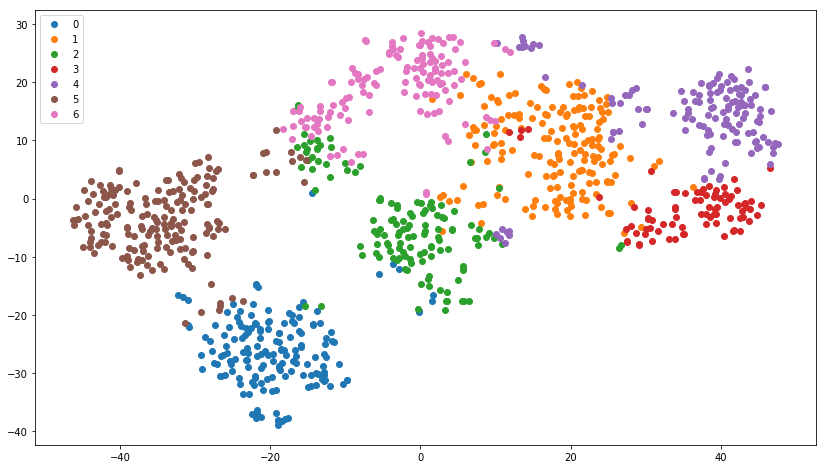

In [20]:
plt.figure(figsize=(14, 8))
plot_tsne_2d(diffs_2d, c);

In [ ]:
c_idx = 1
c_idxs = np.argwhere(c == c_idx).ravel()
c_idxs

In [ ]:
diff_c = np.mean(diffs[c_idxs,:], axis=0)
sns.distplot(diff_c);

In [ ]:
idxs = np.argwhere(np.abs(diff_c) > 0.4)
symbols[idxs.ravel()]

In [ ]:
for s in symbols[idxs.ravel()]:
    print(s)

In [ ]:
diff_c

# Differential expression on real patients

In [406]:
with open('data/rnaseqdb_gen.pkl', 'rb') as f:
    data = pickle.load(f)

In [407]:
x_ = np.concatenate((data['x_test'].astype(np.float32, order='A'), data['x_gen'].astype(np.float32, order='A')), axis=0)
tissue = np.array([tissues_dict_inv[t] for t in cat_covs_test[:, 0]])
t = np.concatenate((tissue, tissue), axis=0)
tissue_idxs = np.argwhere(t == 'colon').ravel()
x_tissue = x_[tissue_idxs]

x_tissue_2d = TSNE(n_components=2).fit_transform(x_tissue)
# x_tissue_2d = tsne_model.transform(x_tissue)

In [408]:
tissue_idxs = np.argwhere(t == 'colon').ravel()
x_tissue = x_[tissue_idxs]
cancer = np.array(['normal' if dataset_dict_inv[q] != 'tcga-t' else 'cancer' for q in data['cat_covs_test'][:, 1]])
cancer = np.concatenate((cancer, cancer), axis=0)
cancer_tissue = cancer[tissue_idxs]

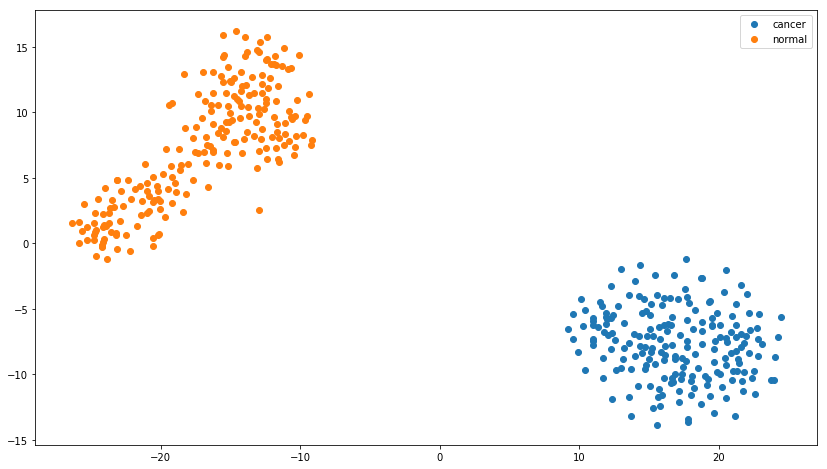

In [409]:
plt.figure(figsize=(14, 8))
plot_tsne_2d(x_tissue_2d, cancer_tissue);

In [410]:
colon_healthy_idxs = [idx for idx, c in enumerate(cancer_tissue) if c == 'normal']

In [411]:
cancer_tissue[colon_healthy_idxs[1]]

'normal'

In [418]:
idx_healthy = 4
x_tissue_ = np.copy(x_tissue)
x_tissue_[colon_healthy_idxs[idx_healthy]] += np.mean(diffs, axis=0)
cancer_tissue_ = np.copy(cancer_tissue)
cancer_tissue_[colon_healthy_idxs[idx_healthy]] = 'after'
x_tissue_2d_ = TSNE(n_components=2, random_state=1).fit_transform(x_tissue_)

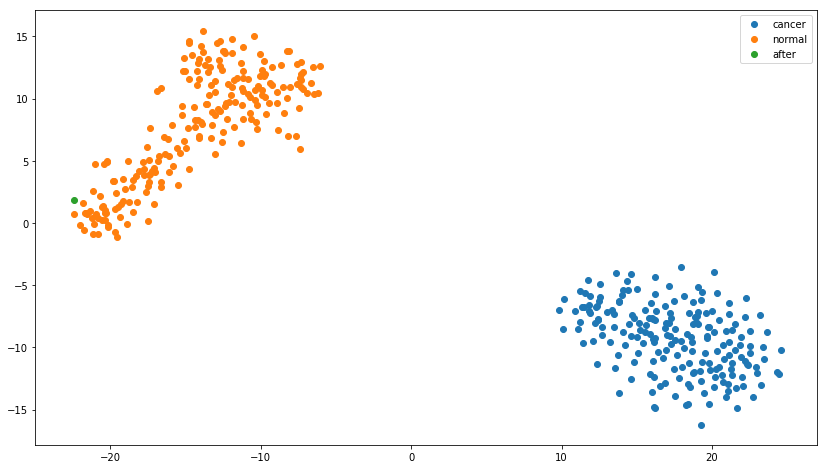

In [419]:
plt.figure(figsize=(14, 8))
plot_tsne_2d(x_tissue_2d_, cancer_tissue_);

# Tissue embeddings

In [54]:
gen.layers[3]

In [55]:
gen.layers[3].get_weights()[0].shape

(15, 4)

In [56]:
gen.layers[3].get_weights()

[array([[ 0.21782109,  0.33044562, -0.2110649 , -0.48806882],
        [-1.176555  ,  0.8234175 , -0.6656099 , -0.78751963],
        [ 0.36925995,  0.18552636, -0.05387821, -0.47199264],
        [-0.03385882,  1.0419681 , -0.8843436 , -0.23923069],
        [-0.7235602 ,  0.44228652, -0.5058131 ,  0.15241274],
        [ 0.65904564, -0.1193627 ,  0.12275134, -0.3114554 ],
        [-0.7932869 ,  0.49230194, -0.48992178,  0.24570431],
        [-0.1405452 , -0.5939319 ,  0.59123725,  0.09831323],
        [ 0.8217675 , -0.57685906,  0.656085  ,  0.56827956],
        [-0.57941407, -0.383813  ,  0.09007376, -0.71254957],
        [ 0.37912887,  0.5051355 , -0.23408169,  0.58538336],
        [ 0.36159936, -0.16780235,  0.12215135, -0.5080895 ],
        [-0.2350056 ,  0.32642832, -0.7904937 , -0.7297764 ],
        [-0.4150838 , -0.05307784,  0.2093259 ,  0.9630771 ],
        [ 0.09878563,  0.18914136, -0.13012429, -0.27970123]],
       dtype=float32)]

In [58]:
gen.layers[4].get_weights()

[array([[ 0.31335112,  0.630104  ],
        [ 0.13727827,  0.59831375],
        [-0.81484073, -0.5148478 ]], dtype=float32)]

In [57]:
tissues_dict_inv

array(['bladder', 'breast', 'cervix', 'colon', 'esophagus_gas',
       'esophagus_muc', 'esophagus_mus', 'kidney', 'liver', 'lung',
       'prostate', 'salivary', 'stomach', 'thyroid', 'uterus'],
      dtype='<U13')

In [ ]:
embeddings = gen.layers[6].get_weights()[0]
emb_2d = tsne_2d(embeddings)

In [ ]:
plt.figure(figsize=(12, 12))
ax = plt.gca()
x1, x2 = emb_2d.T
ax.scatter(x1, x2)

for i, txt in enumerate(tissues_dict_inv):
    ax.annotate(txt, (x1[i], x2[i]),
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center')
    
plt.axis('off');